In [1]:
# Step 1: Let's import some libraries!
import time
import torch
import torch.nn as nn
import torchvision
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import datasets
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import random
from tqdm import tqdm

In [2]:
# This is a new dependency to load this dataset, so make sure you install this module too
from PIL import Image

In [3]:
# batch size
batch_size = 10

In [4]:
traits = ['5_o_Clock_Shadow','Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 
          'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 
          'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 
          'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 
          'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 
          'Wearing_Necktie', 'Young']

In [5]:
def load_celeba(batch_size=40, train=True):

    '''
    Using the dataset and dataloader classes you should be able to make an celebA set and loader
    the loader should use the 'batch_size' argument and the dataset should use'train'
    '''
    
    #############################################
    
    transform = tt.Compose([tt.ToTensor(), tt.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
    
    dataset = torchvision.datasets.CelebA('./', split='train', transform=transform, download=True)
    train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [160000, 162770-160000])

    ##############################################

    return train_dataset, valid_dataset

In [6]:
train_dataset, valid_dataset = load_celeba(train=True, batch_size=batch_size)

Files already downloaded and verified


In [7]:
print(len(train_dataset))

160000


In [8]:
print(len(valid_dataset))

2770


In [9]:
# This just displays a random image from the dataset 
ex_image, ex_label = train_dataset[random.randint(0,100)]
print("ex_image:", ex_image)
print("image shape:", ex_image.shape)
print("image label:", ex_label)

ex_image: tensor([[[-0.5216, -0.5216, -0.5216,  ..., -0.5294, -0.5451, -0.5451],
         [-0.5216, -0.5216, -0.5216,  ..., -0.5294, -0.5451, -0.5451],
         [-0.5216, -0.5216, -0.5216,  ..., -0.5373, -0.5451, -0.5451],
         ...,
         [ 0.0118,  0.0118,  0.0196,  ..., -0.1843, -0.4510, -0.4510],
         [-0.0118, -0.0196, -0.0353,  ..., -0.1529, -0.4510, -0.4667],
         [-0.0118, -0.0196, -0.0353,  ..., -0.2078, -0.4431, -0.4588]],

        [[-0.5216, -0.5216, -0.5216,  ..., -0.4980, -0.5059, -0.5059],
         [-0.5216, -0.5216, -0.5216,  ..., -0.4980, -0.5059, -0.5059],
         [-0.5216, -0.5216, -0.5216,  ..., -0.5059, -0.5059, -0.5059],
         ...,
         [ 0.0118,  0.0118,  0.0196,  ..., -0.6706, -0.6863, -0.6863],
         [-0.0118, -0.0196, -0.0353,  ..., -0.6157, -0.6863, -0.7020],
         [-0.0118, -0.0196, -0.0353,  ..., -0.6471, -0.6863, -0.7020]],

        [[-0.3333, -0.3333, -0.3333,  ..., -0.2706, -0.3333, -0.3333],
         [-0.3333, -0.3333, -0.3333

In [10]:
def plot_image_and_label(image, label):
    
    '''
    Takes in an image and label and shows them using matplotlib 
    this is used to visualize the data and also the outputs of our network
    '''

    plt.imshow(image)
    plt.show()
    return

In [11]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=2)
#         self.conv2 = nn.Conv2d(10, 5, kernel_size=2)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(11395, 512)
#         self.fc2 = nn.Linear(512, 1024)
#         self.fc3 = nn.Linear(1024, 40)
    
#     def forward(self, x):
#         x = F.max_pool2d(self.conv1(x), 2)
#         # print(x.shape)
#         x = F.relu(x)
#         x = F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)
#         # print(x.shape)
#         x = F.relu(x)
#         x = x.view(x.shape[0],-1)
#         # print(x.shape)
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = F.dropout(x, training=self.training)
#         x = self.fc2(x)
#         x = F.relu(x)
#         x = self.fc3(x)
#         return x

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # this is alexnet
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, stride=4, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(30720, 4096)
        self.dropout = nn.Dropout()
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 40)
    
    def forward(self, input):
        # print(output.shape)
        output = F.relu(self.conv1(input))
        output = self.pool(output)
        output = F.relu(self.conv2(output))
        output = self.pool(output)
        output = F.relu(self.conv3(output))
        output = F.relu(self.conv4(output))
        output = F.relu(self.conv5(output))
        oputput = self.pool(output)
        # print(output.shape)
        output = output.view(output.size(0), -1)
        output = self.dropout(output)
        output = F.relu(self.fc1(output))
        output = self.dropout(output)
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        
        return output

In [14]:
model = CNN()

In [15]:
print(model)

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=30720, out_features=4096, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=40, bias=True)
)


In [16]:
# hyper parameters
num_epochs = 1
update_interval = 100
learning_rate = 0.0001

In [17]:
# creating loss function, optimizer, and dataloader
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

In [18]:
test_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

In [19]:
def saveModel():
    path = "./myModel.pth"
    torch.save(model.state.dict(), path)

In [19]:
# def testAccuracy():
    
#     model.eval()
#     accuracy = 0.0
#     total = 0.0
    
#     with torch.no_grad():
#         for data in train_dataloader:
#             images, labels = data
#             # run the model on the test set to predict labels
#             outputs = model(images)
#             # the label with the highest energy will be our prediction
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             accuracy += (predicted == labels).sum().item()
    
#     # compute the accuracy over all test images
#     accuracy = (100 * accuracy / total)
#     return(accuracy)

In [24]:
from torch.autograd import Variable

In [21]:
# losses = []

# for n in range(num_epochs):
#     for i, (image, label) in enumerate(tqdm(iter(train_dataloader))):
#         optimizer.zero_grad()
#         my_label = model(image)
#         loss = loss_function(my_label, label[0])
#         optimizer.grad = loss.backward()
#         optimizer.step()
#         if i % update_interval == 0:
#             losses.append(round(loss.item(), 2))

def train(num_epochs):
    
    losses = []
    
    best_accuracy = 0.0
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    model.to(device)
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_acc = 0.0
        
        for i, (images, labels) in enumerate(tqdm(iter(train_dataloader))):
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            
            optimizer.zero_grad()
            outputs = model(images)
            # print(outputs)
            # print(outputs.shape)
            # print(labels)
            # outputs = outputs.reshape(40, 10)
            # print(outputs.shape)
            # outputs = outputs.float()
            labels = labels.float()
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if i % update_interval == (update_interval-1):
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / update_interval))
                # zero the loss
                # print('labels:', labels)
                # print('outputs:', outputs)
                losses.append(running_loss)
                running_loss = 0.0
            
    return losses
        # accuracy = testAccuracy()
#         print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
#         if accuracy > best_accuracy:
#             saveModel()
#             best_accuracy = accuracy

In [20]:
def imageshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1, 2, 0)))
    plt.show()

In [21]:
model.load_state_dict(torch.load('./alexnet'))

<All keys matched successfully>

In [236]:
losses = train(num_epochs)
print('Finished Training')

The model will be running on cpu device


  1%|▍                                                                       | 100/16000 [02:50<7:08:39,  1.62s/it]

[1,   100] loss: 30.437


  1%|▉                                                                       | 200/16000 [05:34<7:31:08,  1.71s/it]

[1,   200] loss: 30.865


  2%|█▎                                                                      | 300/16000 [08:16<7:11:21,  1.65s/it]

[1,   300] loss: 29.888


  2%|█▊                                                                      | 400/16000 [10:56<6:56:53,  1.60s/it]

[1,   400] loss: 29.564


  3%|██▎                                                                     | 500/16000 [13:36<6:52:27,  1.60s/it]

[1,   500] loss: 29.455


  4%|██▋                                                                     | 600/16000 [16:16<6:49:37,  1.60s/it]

[1,   600] loss: 28.530


  4%|███▏                                                                    | 700/16000 [18:56<6:46:23,  1.59s/it]

[1,   700] loss: 28.494


  5%|███▌                                                                    | 800/16000 [21:35<6:44:03,  1.59s/it]

[1,   800] loss: 27.696


  6%|████                                                                    | 900/16000 [24:15<6:41:22,  1.59s/it]

[1,   900] loss: 28.272


  6%|████▍                                                                  | 1000/16000 [26:56<6:41:47,  1.61s/it]

[1,  1000] loss: 28.122


  7%|████▉                                                                  | 1100/16000 [29:37<6:41:39,  1.62s/it]

[1,  1100] loss: 28.307


  8%|█████▎                                                                 | 1200/16000 [32:19<6:39:13,  1.62s/it]

[1,  1200] loss: 27.778


  8%|█████▊                                                                 | 1300/16000 [35:01<6:37:08,  1.62s/it]

[1,  1300] loss: 27.611


  9%|██████▏                                                                | 1400/16000 [37:44<6:34:43,  1.62s/it]

[1,  1400] loss: 27.505


  9%|██████▋                                                                | 1500/16000 [40:26<6:32:53,  1.63s/it]

[1,  1500] loss: 27.628


 10%|███████                                                                | 1600/16000 [43:09<6:30:14,  1.63s/it]

[1,  1600] loss: 27.232


 11%|███████▌                                                               | 1700/16000 [45:51<6:27:12,  1.62s/it]

[1,  1700] loss: 27.170


 11%|███████▉                                                               | 1800/16000 [48:34<6:25:17,  1.63s/it]

[1,  1800] loss: 27.445


 12%|████████▍                                                              | 1900/16000 [51:16<6:22:28,  1.63s/it]

[1,  1900] loss: 27.762


 12%|████████▉                                                              | 2000/16000 [53:59<6:19:15,  1.63s/it]

[1,  2000] loss: 27.332


 13%|█████████▎                                                             | 2100/16000 [56:42<6:12:19,  1.61s/it]

[1,  2100] loss: 26.894


 14%|█████████▊                                                             | 2200/16000 [59:23<6:07:26,  1.60s/it]

[1,  2200] loss: 27.392


 14%|█████████▉                                                           | 2300/16000 [1:02:02<6:04:34,  1.60s/it]

[1,  2300] loss: 26.722


 15%|██████████▎                                                          | 2400/16000 [1:04:42<6:02:32,  1.60s/it]

[1,  2400] loss: 26.914


 16%|██████████▊                                                          | 2500/16000 [1:07:22<5:59:52,  1.60s/it]

[1,  2500] loss: 27.033


 16%|███████████▏                                                         | 2600/16000 [1:10:02<5:57:29,  1.60s/it]

[1,  2600] loss: 27.222


 17%|███████████▋                                                         | 2700/16000 [1:12:42<5:56:12,  1.61s/it]

[1,  2700] loss: 26.531


 18%|████████████                                                         | 2800/16000 [1:15:22<5:51:39,  1.60s/it]

[1,  2800] loss: 27.001


 18%|████████████▌                                                        | 2900/16000 [1:18:03<5:50:59,  1.61s/it]

[1,  2900] loss: 26.356


 19%|████████████▉                                                        | 3000/16000 [1:20:44<5:53:34,  1.63s/it]

[1,  3000] loss: 26.426


 19%|█████████████▎                                                       | 3100/16000 [1:23:26<5:48:09,  1.62s/it]

[1,  3100] loss: 26.995


 20%|█████████████▊                                                       | 3200/16000 [1:26:07<5:40:52,  1.60s/it]

[1,  3200] loss: 26.760


 21%|██████████████▏                                                      | 3300/16000 [1:28:47<5:37:47,  1.60s/it]

[1,  3300] loss: 26.470


 21%|██████████████▋                                                      | 3400/16000 [1:31:27<5:35:16,  1.60s/it]

[1,  3400] loss: 26.830


 22%|███████████████                                                      | 3500/16000 [1:34:06<5:32:37,  1.60s/it]

[1,  3500] loss: 26.785


 22%|███████████████▌                                                     | 3600/16000 [1:36:46<5:30:06,  1.60s/it]

[1,  3600] loss: 26.620


 23%|███████████████▉                                                     | 3700/16000 [1:39:26<5:27:17,  1.60s/it]

[1,  3700] loss: 26.550


 24%|████████████████▍                                                    | 3800/16000 [1:42:06<5:26:07,  1.60s/it]

[1,  3800] loss: 26.088


 24%|████████████████▊                                                    | 3900/16000 [1:44:46<5:24:22,  1.61s/it]

[1,  3900] loss: 26.704


 25%|█████████████████▎                                                   | 4000/16000 [1:47:26<5:19:06,  1.60s/it]

[1,  4000] loss: 26.501


 26%|█████████████████▋                                                   | 4100/16000 [1:50:05<5:16:58,  1.60s/it]

[1,  4100] loss: 26.160


 26%|██████████████████                                                   | 4200/16000 [1:52:45<5:16:21,  1.61s/it]

[1,  4200] loss: 26.309


 27%|██████████████████▌                                                  | 4300/16000 [1:55:25<5:11:02,  1.60s/it]

[1,  4300] loss: 26.709


 28%|██████████████████▉                                                  | 4400/16000 [1:58:04<5:08:44,  1.60s/it]

[1,  4400] loss: 26.267


 28%|███████████████████▍                                                 | 4500/16000 [2:00:44<5:06:14,  1.60s/it]

[1,  4500] loss: 26.078


 29%|███████████████████▊                                                 | 4600/16000 [2:03:23<5:02:38,  1.59s/it]

[1,  4600] loss: 26.443


 29%|████████████████████▎                                                | 4700/16000 [2:06:05<5:04:47,  1.62s/it]

[1,  4700] loss: 26.476


 30%|████████████████████▋                                                | 4800/16000 [2:08:47<5:03:27,  1.63s/it]

[1,  4800] loss: 26.456


 31%|█████████████████████▏                                               | 4900/16000 [2:11:30<5:00:13,  1.62s/it]

[1,  4900] loss: 26.295


 31%|█████████████████████▌                                               | 5000/16000 [2:14:13<4:56:54,  1.62s/it]

[1,  5000] loss: 26.177


 32%|█████████████████████▉                                               | 5100/16000 [2:16:55<4:53:46,  1.62s/it]

[1,  5100] loss: 26.031


 32%|██████████████████████▍                                              | 5200/16000 [2:19:37<4:52:25,  1.62s/it]

[1,  5200] loss: 26.427


 33%|██████████████████████▊                                              | 5300/16000 [2:22:19<4:48:48,  1.62s/it]

[1,  5300] loss: 26.371


 34%|███████████████████████▎                                             | 5400/16000 [2:25:02<4:46:55,  1.62s/it]

[1,  5400] loss: 26.437


 34%|███████████████████████▋                                             | 5500/16000 [2:27:44<4:44:05,  1.62s/it]

[1,  5500] loss: 26.048


 35%|████████████████████████▏                                            | 5600/16000 [2:30:26<4:40:59,  1.62s/it]

[1,  5600] loss: 26.483


 36%|████████████████████████▌                                            | 5700/16000 [2:33:08<4:39:12,  1.63s/it]

[1,  5700] loss: 26.336


 36%|█████████████████████████                                            | 5800/16000 [2:35:51<4:36:26,  1.63s/it]

[1,  5800] loss: 26.042


 37%|█████████████████████████▍                                           | 5900/16000 [2:38:33<4:34:09,  1.63s/it]

[1,  5900] loss: 26.733


 38%|█████████████████████████▉                                           | 6000/16000 [2:41:16<4:30:23,  1.62s/it]

[1,  6000] loss: 26.731


 38%|██████████████████████████▎                                          | 6100/16000 [2:43:59<4:28:36,  1.63s/it]

[1,  6100] loss: 25.674


 39%|██████████████████████████▋                                          | 6200/16000 [2:46:41<4:25:40,  1.63s/it]

[1,  6200] loss: 26.910


 39%|███████████████████████████▏                                         | 6300/16000 [2:49:24<4:23:19,  1.63s/it]

[1,  6300] loss: 25.937


 40%|███████████████████████████▌                                         | 6400/16000 [2:52:07<4:20:25,  1.63s/it]

[1,  6400] loss: 26.440


 41%|████████████████████████████                                         | 6500/16000 [2:54:50<4:19:07,  1.64s/it]

[1,  6500] loss: 25.758


 41%|████████████████████████████▍                                        | 6600/16000 [2:57:33<4:15:06,  1.63s/it]

[1,  6600] loss: 26.272


 42%|████████████████████████████▉                                        | 6700/16000 [3:00:14<4:11:23,  1.62s/it]

[1,  6700] loss: 26.309


 42%|█████████████████████████████▎                                       | 6800/16000 [3:02:57<4:09:29,  1.63s/it]

[1,  6800] loss: 25.784


 43%|█████████████████████████████▊                                       | 6900/16000 [3:05:40<4:06:00,  1.62s/it]

[1,  6900] loss: 26.062


 44%|██████████████████████████████▏                                      | 7000/16000 [3:08:23<4:04:13,  1.63s/it]

[1,  7000] loss: 26.062


 44%|██████████████████████████████▌                                      | 7100/16000 [3:11:06<4:02:36,  1.64s/it]

[1,  7100] loss: 25.746


 45%|███████████████████████████████                                      | 7200/16000 [3:13:49<3:58:48,  1.63s/it]

[1,  7200] loss: 26.238


 46%|███████████████████████████████▍                                     | 7300/16000 [3:16:32<3:56:16,  1.63s/it]

[1,  7300] loss: 26.204


 46%|███████████████████████████████▉                                     | 7400/16000 [3:19:14<3:52:01,  1.62s/it]

[1,  7400] loss: 25.677


 47%|████████████████████████████████▎                                    | 7500/16000 [3:21:57<3:50:33,  1.63s/it]

[1,  7500] loss: 26.674


 48%|████████████████████████████████▊                                    | 7600/16000 [3:24:39<3:46:25,  1.62s/it]

[1,  7600] loss: 26.177


 48%|█████████████████████████████████▏                                   | 7700/16000 [3:27:21<3:44:19,  1.62s/it]

[1,  7700] loss: 25.866


 49%|█████████████████████████████████▋                                   | 7800/16000 [3:30:04<3:43:26,  1.63s/it]

[1,  7800] loss: 26.318


 49%|██████████████████████████████████                                   | 7900/16000 [3:32:46<3:39:08,  1.62s/it]

[1,  7900] loss: 26.267


 50%|██████████████████████████████████▌                                  | 8000/16000 [3:35:29<3:37:10,  1.63s/it]

[1,  8000] loss: 25.904


 51%|██████████████████████████████████▉                                  | 8100/16000 [3:38:11<3:33:31,  1.62s/it]

[1,  8100] loss: 26.385


 51%|███████████████████████████████████▎                                 | 8200/16000 [3:40:54<3:32:15,  1.63s/it]

[1,  8200] loss: 26.078


 52%|███████████████████████████████████▊                                 | 8300/16000 [3:43:36<3:28:43,  1.63s/it]

[1,  8300] loss: 26.213


 52%|████████████████████████████████████▏                                | 8400/16000 [3:46:19<3:26:10,  1.63s/it]

[1,  8400] loss: 25.681


 53%|████████████████████████████████████▋                                | 8500/16000 [3:49:01<3:24:38,  1.64s/it]

[1,  8500] loss: 26.448


 54%|█████████████████████████████████████                                | 8600/16000 [3:51:44<3:21:08,  1.63s/it]

[1,  8600] loss: 26.577


 54%|█████████████████████████████████████▌                               | 8700/16000 [3:54:26<3:17:56,  1.63s/it]

[1,  8700] loss: 26.257


 55%|█████████████████████████████████████▉                               | 8800/16000 [3:57:09<3:15:08,  1.63s/it]

[1,  8800] loss: 26.117


 56%|██████████████████████████████████████▍                              | 8900/16000 [3:59:52<3:11:35,  1.62s/it]

[1,  8900] loss: 25.996


 56%|██████████████████████████████████████▊                              | 9000/16000 [4:02:34<3:09:00,  1.62s/it]

[1,  9000] loss: 25.838


 57%|███████████████████████████████████████▏                             | 9100/16000 [4:05:16<3:06:38,  1.62s/it]

[1,  9100] loss: 26.248


 57%|███████████████████████████████████████▋                             | 9200/16000 [4:07:59<3:06:54,  1.65s/it]

[1,  9200] loss: 26.033


 58%|████████████████████████████████████████                             | 9300/16000 [4:10:42<3:01:15,  1.62s/it]

[1,  9300] loss: 25.676


 59%|████████████████████████████████████████▌                            | 9400/16000 [4:13:24<2:58:49,  1.63s/it]

[1,  9400] loss: 25.435


 59%|████████████████████████████████████████▉                            | 9500/16000 [4:16:06<2:55:33,  1.62s/it]

[1,  9500] loss: 26.335


 60%|█████████████████████████████████████████▍                           | 9600/16000 [4:18:49<2:53:05,  1.62s/it]

[1,  9600] loss: 26.187


 61%|█████████████████████████████████████████▊                           | 9700/16000 [4:21:30<2:50:59,  1.63s/it]

[1,  9700] loss: 25.573


 61%|██████████████████████████████████████████▎                          | 9800/16000 [4:24:13<2:48:16,  1.63s/it]

[1,  9800] loss: 26.115


 62%|██████████████████████████████████████████▋                          | 9900/16000 [4:26:56<2:45:35,  1.63s/it]

[1,  9900] loss: 26.391


 62%|██████████████████████████████████████████▌                         | 10000/16000 [4:29:38<2:42:58,  1.63s/it]

[1, 10000] loss: 25.924


 63%|██████████████████████████████████████████▉                         | 10100/16000 [4:32:21<2:40:08,  1.63s/it]

[1, 10100] loss: 25.938


 64%|███████████████████████████████████████████▎                        | 10200/16000 [4:35:04<2:37:41,  1.63s/it]

[1, 10200] loss: 26.446


 64%|███████████████████████████████████████████▊                        | 10300/16000 [4:37:46<2:34:17,  1.62s/it]

[1, 10300] loss: 25.871


 65%|████████████████████████████████████████████▏                       | 10400/16000 [4:40:29<2:31:46,  1.63s/it]

[1, 10400] loss: 26.057


 66%|████████████████████████████████████████████▋                       | 10500/16000 [4:43:11<2:29:59,  1.64s/it]

[1, 10500] loss: 25.716


 66%|█████████████████████████████████████████████                       | 10600/16000 [4:45:54<2:26:27,  1.63s/it]

[1, 10600] loss: 26.004


 67%|█████████████████████████████████████████████▍                      | 10700/16000 [4:48:36<2:23:53,  1.63s/it]

[1, 10700] loss: 25.790


 68%|█████████████████████████████████████████████▉                      | 10800/16000 [4:51:19<2:21:12,  1.63s/it]

[1, 10800] loss: 25.361


 68%|██████████████████████████████████████████████▎                     | 10900/16000 [4:54:02<2:17:50,  1.62s/it]

[1, 10900] loss: 25.850


 69%|██████████████████████████████████████████████▊                     | 11000/16000 [4:56:44<2:15:25,  1.63s/it]

[1, 11000] loss: 25.287


 69%|███████████████████████████████████████████████▏                    | 11100/16000 [4:59:27<2:12:49,  1.63s/it]

[1, 11100] loss: 26.239


 70%|███████████████████████████████████████████████▌                    | 11200/16000 [5:02:10<2:09:38,  1.62s/it]

[1, 11200] loss: 25.457


 71%|████████████████████████████████████████████████                    | 11300/16000 [5:04:51<2:06:33,  1.62s/it]

[1, 11300] loss: 25.689


 71%|████████████████████████████████████████████████▍                   | 11400/16000 [5:07:34<2:05:06,  1.63s/it]

[1, 11400] loss: 25.807


 72%|████████████████████████████████████████████████▉                   | 11500/16000 [5:10:17<2:01:53,  1.63s/it]

[1, 11500] loss: 25.791


 72%|█████████████████████████████████████████████████▎                  | 11600/16000 [5:12:59<1:59:15,  1.63s/it]

[1, 11600] loss: 25.769


 73%|█████████████████████████████████████████████████▋                  | 11700/16000 [5:15:42<1:56:08,  1.62s/it]

[1, 11700] loss: 25.697


 74%|██████████████████████████████████████████████████▏                 | 11800/16000 [5:18:24<1:53:32,  1.62s/it]

[1, 11800] loss: 25.451


 74%|██████████████████████████████████████████████████▌                 | 11900/16000 [5:21:06<1:50:39,  1.62s/it]

[1, 11900] loss: 25.772


 75%|███████████████████████████████████████████████████                 | 12000/16000 [5:23:48<1:47:48,  1.62s/it]

[1, 12000] loss: 26.006


 76%|███████████████████████████████████████████████████▍                | 12100/16000 [5:26:30<1:45:42,  1.63s/it]

[1, 12100] loss: 25.844


 76%|███████████████████████████████████████████████████▊                | 12200/16000 [5:29:12<1:42:48,  1.62s/it]

[1, 12200] loss: 26.199


 77%|████████████████████████████████████████████████████▎               | 12300/16000 [5:31:55<1:40:11,  1.62s/it]

[1, 12300] loss: 25.877


 78%|████████████████████████████████████████████████████▋               | 12400/16000 [5:34:38<1:37:31,  1.63s/it]

[1, 12400] loss: 25.478


 78%|█████████████████████████████████████████████████████▏              | 12500/16000 [5:37:21<1:34:58,  1.63s/it]

[1, 12500] loss: 26.052


 79%|█████████████████████████████████████████████████████▌              | 12600/16000 [5:40:03<1:31:51,  1.62s/it]

[1, 12600] loss: 25.843


 79%|█████████████████████████████████████████████████████▉              | 12700/16000 [5:42:46<1:29:07,  1.62s/it]

[1, 12700] loss: 25.784


 80%|██████████████████████████████████████████████████████▍             | 12800/16000 [5:45:28<1:26:34,  1.62s/it]

[1, 12800] loss: 25.901


 81%|██████████████████████████████████████████████████████▊             | 12900/16000 [5:48:10<1:23:46,  1.62s/it]

[1, 12900] loss: 25.346


 81%|███████████████████████████████████████████████████████▎            | 13000/16000 [5:50:52<1:21:02,  1.62s/it]

[1, 13000] loss: 26.149


 82%|███████████████████████████████████████████████████████▋            | 13100/16000 [5:53:35<1:18:27,  1.62s/it]

[1, 13100] loss: 25.738


 82%|████████████████████████████████████████████████████████            | 13200/16000 [5:56:17<1:15:54,  1.63s/it]

[1, 13200] loss: 25.669


 83%|████████████████████████████████████████████████████████▌           | 13300/16000 [5:59:00<1:13:21,  1.63s/it]

[1, 13300] loss: 25.449


 84%|████████████████████████████████████████████████████████▉           | 13400/16000 [6:01:43<1:10:31,  1.63s/it]

[1, 13400] loss: 25.947


 84%|█████████████████████████████████████████████████████████▍          | 13500/16000 [6:04:25<1:07:50,  1.63s/it]

[1, 13500] loss: 25.496


 85%|█████████████████████████████████████████████████████████▊          | 13600/16000 [6:07:07<1:04:52,  1.62s/it]

[1, 13600] loss: 25.750


 86%|██████████████████████████████████████████████████████████▏         | 13700/16000 [6:09:50<1:02:13,  1.62s/it]

[1, 13700] loss: 24.900


 86%|████████████████████████████████████████████████████████████▍         | 13800/16000 [6:12:32<59:36,  1.63s/it]

[1, 13800] loss: 25.981


 87%|████████████████████████████████████████████████████████████▊         | 13900/16000 [6:15:14<56:47,  1.62s/it]

[1, 13900] loss: 26.007


 88%|█████████████████████████████████████████████████████████████▎        | 14000/16000 [6:17:57<54:17,  1.63s/it]

[1, 14000] loss: 25.922


 88%|█████████████████████████████████████████████████████████████▋        | 14100/16000 [6:20:39<51:32,  1.63s/it]

[1, 14100] loss: 26.462


 89%|██████████████████████████████████████████████████████████████▏       | 14200/16000 [6:23:22<48:45,  1.63s/it]

[1, 14200] loss: 25.409


 89%|██████████████████████████████████████████████████████████████▌       | 14300/16000 [6:26:04<46:09,  1.63s/it]

[1, 14300] loss: 25.948


 90%|███████████████████████████████████████████████████████████████       | 14400/16000 [6:28:46<43:07,  1.62s/it]

[1, 14400] loss: 25.815


 91%|███████████████████████████████████████████████████████████████▍      | 14500/16000 [6:31:28<40:33,  1.62s/it]

[1, 14500] loss: 25.200


 91%|███████████████████████████████████████████████████████████████▉      | 14600/16000 [6:34:10<37:59,  1.63s/it]

[1, 14600] loss: 26.202


 92%|████████████████████████████████████████████████████████████████▎     | 14700/16000 [6:36:52<35:09,  1.62s/it]

[1, 14700] loss: 25.930


 92%|████████████████████████████████████████████████████████████████▊     | 14800/16000 [6:39:35<32:39,  1.63s/it]

[1, 14800] loss: 25.653


 93%|█████████████████████████████████████████████████████████████████▏    | 14900/16000 [6:42:18<29:47,  1.63s/it]

[1, 14900] loss: 26.180


 94%|█████████████████████████████████████████████████████████████████▋    | 15000/16000 [6:45:00<27:05,  1.63s/it]

[1, 15000] loss: 25.439


 94%|██████████████████████████████████████████████████████████████████    | 15100/16000 [6:47:43<24:16,  1.62s/it]

[1, 15100] loss: 25.445


 95%|██████████████████████████████████████████████████████████████████▌   | 15200/16000 [6:50:25<21:37,  1.62s/it]

[1, 15200] loss: 25.615


 96%|██████████████████████████████████████████████████████████████████▉   | 15300/16000 [6:53:08<19:01,  1.63s/it]

[1, 15300] loss: 25.516


 96%|███████████████████████████████████████████████████████████████████▍  | 15400/16000 [6:55:51<16:20,  1.63s/it]

[1, 15400] loss: 25.763


 97%|███████████████████████████████████████████████████████████████████▊  | 15500/16000 [6:58:35<13:34,  1.63s/it]

[1, 15500] loss: 25.663


 98%|████████████████████████████████████████████████████████████████████▎ | 15600/16000 [7:01:17<10:51,  1.63s/it]

[1, 15600] loss: 25.997


 98%|████████████████████████████████████████████████████████████████████▋ | 15700/16000 [7:04:00<08:06,  1.62s/it]

[1, 15700] loss: 25.328


 99%|█████████████████████████████████████████████████████████████████████▏| 15800/16000 [7:06:41<05:23,  1.62s/it]

[1, 15800] loss: 25.644


 99%|█████████████████████████████████████████████████████████████████████▌| 15900/16000 [7:09:24<02:43,  1.63s/it]

[1, 15900] loss: 25.793


100%|██████████████████████████████████████████████████████████████████████| 16000/16000 [7:12:07<00:00,  1.62s/it]

[1, 16000] loss: 25.137
Finished Training


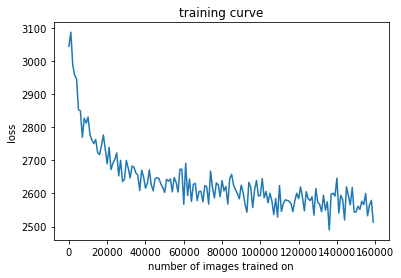

In [237]:
plt.plot(np.arange(len(losses)) * batch_size * update_interval, losses)
plt.title("training curve")
plt.xlabel("number of images trained on")
plt.ylabel("loss")
plt.show()

In [23]:
avgLoss = sum(losses)/len(losses)
print("Average loss: ", avgLoss)
minLoss = min(losses)
print("Minimum loss: ", minLoss)
finLoss = losses[len(losses)-1]
print("Final loss: ", finLoss)

NameError: name 'losses' is not defined

In [240]:
torch.save(model.state_dict(), './alexnet')

In [25]:
def testRand():
    image, label = valid_dataset[random.randint(0, 2770)]
    # print(image)
    # print(image.shape)
    image = Variable(image, requires_grad=False)
    imageshow(image)
    image = image.unsqueeze(0)
    out = model(image)
    # print(out)
    out = (out>0.5).int()
    outList = out.tolist()[0]
    display(image)
    print('Real labels: ', label)
    print('Predicted: ', out)
    print()
    print('Traits detected:')
    for i in range(len(outList)):
        if outList[i] == 1:
            print(traits[i])
    print()
    print('Actual traits:')
    labelList = label.tolist()
    # print(labelList)
    for i in range(len(labelList)):
        if labelList[i] == 1:
            print(traits[i])
    print()
    accuracy = (40-((label ^ out[0]) == 1).sum(dim=0).tolist())/40
    print('Accuracy: ', accuracy * 100, '%')

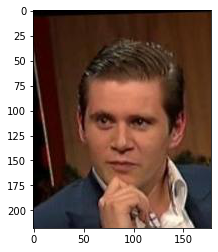

tensor([[[[-0.9529, -0.9529, -0.9529,  ..., -0.9451, -0.9373, -0.9373],
          [-0.9608, -0.9608, -0.9608,  ..., -0.8196, -0.7961, -0.7961],
          [-0.9608, -0.9608, -0.9608,  ..., -0.6471, -0.6314, -0.6314],
          ...,
          [-0.7020, -0.7020, -0.6941,  ..., -0.7569, -0.7020, -0.7020],
          [-0.7333, -0.7255, -0.7176,  ..., -0.7490, -0.7098, -0.7098],
          [-0.7333, -0.7255, -0.7176,  ..., -0.7490, -0.7098, -0.7098]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9922, -0.9922],
          [-1.0000, -1.0000, -1.0000,  ..., -0.9059, -0.8745, -0.8745],
          [-0.9922, -0.9922, -0.9922,  ..., -0.7882, -0.7647, -0.7647],
          ...,
          [-0.6314, -0.6314, -0.6235,  ..., -0.7020, -0.7098, -0.7098],
          [-0.6784, -0.6706, -0.6627,  ..., -0.6941, -0.7176, -0.7176],
          [-0.6784, -0.6706, -0.6627,  ..., -0.6941, -0.7176, -0.7176]],

         [[-0.9686, -0.9686, -0.9686,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9686, -0.9686, -

Real labels:  tensor([0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1])
Predicted:  tensor([[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
         1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]], dtype=torch.int32)

Traits detected:
Attractive
Bags_Under_Eyes
Big_Nose
Brown_Hair
High_Cheekbones
Male
No_Beard
Oval_Face
Smiling
Straight_Hair
Young

Actual traits:
Attractive
Bags_Under_Eyes
Black_Hair
Male
No_Beard
Oval_Face
Straight_Hair
Young

Accuracy:  87.5 %


In [26]:
testRand()

In [27]:
def testBatch():
    accuracies = []
    images, labels = next(iter(test_dataloader))
    # imageshow(torchvision.utils.make_grid(images))
    # print('Real labels: ', labels)
    outputs = model(images)
    outputs = (outputs>0.5).int()
    # print('Predicted: ', outputs)
    for x in range(len(images)):
        imageshow(images[x])
        print('Real labels: ', labels[x])
        print('Predicted: ', outputs[x])
        accuracy = (40-((labels[x] ^ outputs[x]) == 1).sum(dim=0).tolist())/40
        accuracies.append(accuracy)
        print('Accuracy: ', accuracy)
        print()
        print('Traits detected:')
        outputList = outputs[x].tolist()
        for i in range(len(outputList)):
            if outputList[i] == 1:
                print(traits[i])
        print()
        print('Actual traits:')
        labelList = labels[x].tolist()
        for i in range(len(labelList)):
            if labelList[i] == 1:
                print(traits[i])
    return accuracies

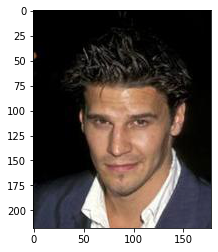

Real labels:  tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
Predicted:  tensor([1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1], dtype=torch.int32)
Accuracy:  0.725

Traits detected:
5_o_Clock_Shadow
Attractive
Bags_Under_Eyes
Big_Nose
Black_Hair
Bushy_Eyebrows
High_Cheekbones
Male
No_Beard
Oval_Face
Smiling
Straight_Hair
Wavy_Hair
Young

Actual traits:
Attractive
Male
No_Beard
Pointy_Nose
Young


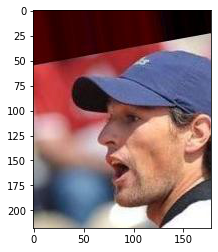

Real labels:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1])
Predicted:  tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1], dtype=torch.int32)
Accuracy:  0.875

Traits detected:
Big_Nose
Chubby
Eyeglasses
High_Cheekbones
Male
Mouth_Slightly_Open
No_Beard
Oval_Face
Wearing_Hat
Young

Actual traits:
Male
Mouth_Slightly_Open
No_Beard
Wearing_Hat
Young


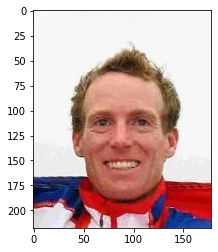

Real labels:  tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])
Predicted:  tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1], dtype=torch.int32)
Accuracy:  0.95

Traits detected:
Bags_Under_Eyes
Big_Nose
Brown_Hair
High_Cheekbones
Male
Mouth_Slightly_Open
Narrow_Eyes
No_Beard
Oval_Face
Smiling
Young

Actual traits:
Bags_Under_Eyes
Brown_Hair
High_Cheekbones
Male
Mouth_Slightly_Open
No_Beard
Oval_Face
Smiling
Young


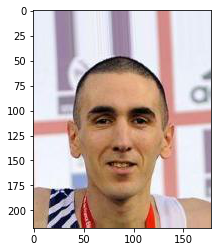

Real labels:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])
Predicted:  tensor([0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1], dtype=torch.int32)
Accuracy:  0.875

Traits detected:
Bags_Under_Eyes
Big_Lips
Big_Nose
Black_Hair
Bushy_Eyebrows
High_Cheekbones
Male
Mouth_Slightly_Open
No_Beard
Oval_Face
Receding_Hairline
Smiling
Young

Actual traits:
Black_Hair
Bushy_Eyebrows
High_Cheekbones
Male
Mouth_Slightly_Open
No_Beard
Smiling
Young


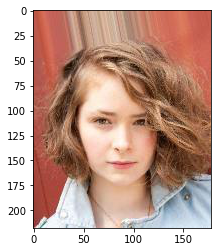

Real labels:  tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1])
Predicted:  tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1], dtype=torch.int32)
Accuracy:  0.825

Traits detected:
Attractive
Bangs
Big_Lips
Brown_Hair
Male
No_Beard
Pale_Skin
Pointy_Nose
Wavy_Hair
Wearing_Lipstick
Young

Actual traits:
Attractive
No_Beard
Pointy_Nose
Wavy_Hair
Wearing_Necklace
Young


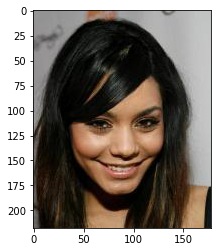

Real labels:  tensor([0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1])
Predicted:  tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1], dtype=torch.int32)
Accuracy:  0.875

Traits detected:
Arched_Eyebrows
Attractive
Bags_Under_Eyes
Bangs
Big_Lips
Big_Nose
Black_Hair
Heavy_Makeup
High_Cheekbones
Mouth_Slightly_Open
No_Beard
Oval_Face
Smiling
Wavy_Hair
Wearing_Lipstick
Young

Actual traits:
Attractive
Bags_Under_Eyes
Bangs
Big_Nose
Heavy_Makeup
High_Cheekbones
No_Beard
Oval_Face
Smiling
Wearing_Lipstick
Young


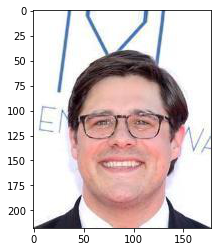

Real labels:  tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1])
Predicted:  tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1], dtype=torch.int32)
Accuracy:  0.775

Traits detected:
Big_Nose
Black_Hair
Eyeglasses
High_Cheekbones
Male
Mouth_Slightly_Open
No_Beard
Oval_Face
Smiling
Wearing_Necktie
Young

Actual traits:
Bags_Under_Eyes
Big_Nose
Chubby
Double_Chin
Eyeglasses
Male
Mouth_Slightly_Open
Narrow_Eyes
Smiling
Straight_Hair
Wearing_Necktie
Young


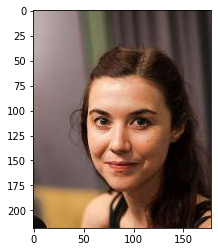

Real labels:  tensor([0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1])
Predicted:  tensor([0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1], dtype=torch.int32)
Accuracy:  0.8

Traits detected:
Arched_Eyebrows
Attractive
Bags_Under_Eyes
Big_Lips
Big_Nose
Brown_Hair
Bushy_Eyebrows
Heavy_Makeup
High_Cheekbones
No_Beard
Oval_Face
Smiling
Wavy_Hair
Wearing_Earrings
Wearing_Lipstick
Young

Actual traits:
Arched_Eyebrows
Attractive
Bags_Under_Eyes
Big_Nose
High_Cheekbones
No_Beard
Wearing_Lipstick
Young


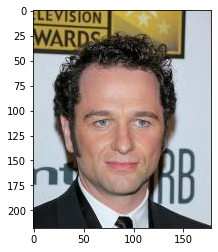

Real labels:  tensor([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])
Predicted:  tensor([1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1], dtype=torch.int32)
Accuracy:  0.8

Traits detected:
5_o_Clock_Shadow
Attractive
Bags_Under_Eyes
Big_Nose
Black_Hair
High_Cheekbones
Male
No_Beard
Oval_Face
Pointy_Nose
Smiling
Straight_Hair
Wearing_Necktie
Young

Actual traits:
5_o_Clock_Shadow
Bags_Under_Eyes
Big_Nose
Male
No_Beard
Pointy_Nose
Wavy_Hair
Wearing_Necktie


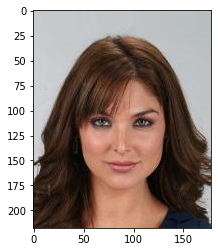

Real labels:  tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1])
Predicted:  tensor([0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1], dtype=torch.int32)
Accuracy:  0.9

Traits detected:
Arched_Eyebrows
Attractive
Bangs
Big_Lips
Brown_Hair
Heavy_Makeup
High_Cheekbones
No_Beard
Oval_Face
Pointy_Nose
Smiling
Wavy_Hair
Wearing_Earrings
Wearing_Lipstick
Wearing_Necklace
Young

Actual traits:
Attractive
Bangs
Brown_Hair
Heavy_Makeup
High_Cheekbones
No_Beard
Oval_Face
Pointy_Nose
Smiling
Wavy_Hair
Wearing_Lipstick
Young


In [28]:
accuracies = testBatch()

In [29]:
print("Average accuracy: ", sum(accuracies)/len(accuracies)*100, '%')

Average accuracy:  84.00000000000001 %


In [30]:
def test():
    losses = []
    # accuracies = []
    for i, (images, labels) in enumerate(tqdm(iter(test_dataloader))):
        outputs = model(images)
        loss = loss_function(outputs, labels.float())
        losses.append(loss)
        # for x in range(len(images)):
        #     accuracy = (40-((labels[x].int() ^ outputs[x].int()) == 1).sum(dim=0).tolist())/40
        #     accuracies.append(accuracy)
    return sum(losses)/len(losses) # , sum(accuracies)/len(accuracies)

In [30]:
avgTestLoss = test()
print('Average test loss: ', avgTestLoss)
# print('Average test accuracy: ', avgTestAccuracy)

  3%|█▋                                                   | 9/277 [00:03<01:55,  2.32it/s]


KeyboardInterrupt: 

In [31]:
def loadImage(path):
    image = Image.open(path)
    loader = tt.Compose([tt.Resize((960, 1440)), tt.CenterCrop((872, 712)), 
                                 tt.Resize((218, 178)), 
                                 tt.ToTensor(), 
                                 tt.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
    cropper = tt.Compose([tt.Resize((960, 1440)),tt.CenterCrop((872, 712)), tt.Resize((218, 178))])
    imageTensor = loader(image).float()
    imageTensor = Variable(imageTensor, requires_grad=True)
    imageTensor = imageTensor.unsqueeze(0)
    return imageTensor, cropper(image)

In [32]:
def printResults(path):
    tensor, image = loadImage(path)
    out = model(tensor)
    out = (out>0.5).int()
    outList = out.tolist()[0]
    display(image)
    print('Predicted: ', out)
    print('Traits detected:')
    for i in range(len(outList)):
        if outList[i] == 1:
            print(traits[i])

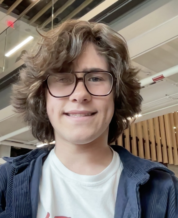

Predicted:  tensor([[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]], dtype=torch.int32)
Traits detected:
Bangs
Big_Nose
Blurry
Brown_Hair
Male
Narrow_Eyes
No_Beard
Wavy_Hair
Young


In [33]:
printResults('./imga.jpg')

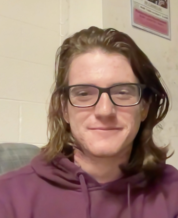

Predicted:  tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=torch.int32)
Traits detected:
Big_Nose
Blurry
Bushy_Eyebrows
Male
No_Beard
Young


In [362]:
printResults('./imgh.jpg')

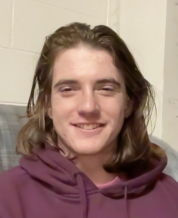

Predicted:  tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
         1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]], dtype=torch.int32)
Traits detected:
Attractive
Blurry
Brown_Hair
Male
Narrow_Eyes
No_Beard
Pointy_Nose
Wavy_Hair
Young


In [363]:
printResults('./imgi.jpg')

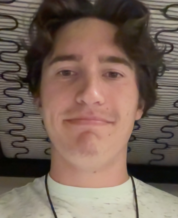

Predicted:  tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
         1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)
Traits detected:
Big_Nose
Blurry
Gray_Hair
High_Cheekbones
Male
Mouth_Slightly_Open
Narrow_Eyes
No_Beard
Receding_Hairline


In [364]:
printResults('./imgj.jpg')

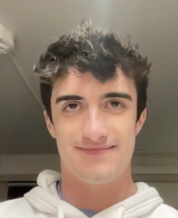

Predicted:  tensor([[0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]], dtype=torch.int32)
Traits detected:
Attractive
Bags_Under_Eyes
Big_Nose
Black_Hair
Brown_Hair
Bushy_Eyebrows
Male
No_Beard
Oval_Face
Smiling
Straight_Hair
Young


In [367]:
printResults('./imgk.jpg')

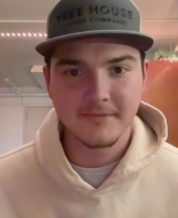

Predicted:  tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
         1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=torch.int32)
Traits detected:
Blond_Hair
Blurry
High_Cheekbones
Mouth_Slightly_Open
Narrow_Eyes
No_Beard
Smiling
Young


In [34]:
printResults('./imgl.jpg')

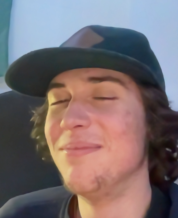

Predicted:  tensor([[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]], dtype=torch.int32)
Traits detected:
Bags_Under_Eyes
Big_Nose
Blurry
Chubby
Male
Narrow_Eyes
No_Beard
Wearing_Hat
Young


In [35]:
printResults('./imgm.jpg')

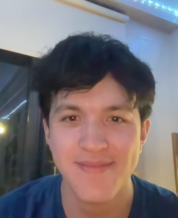

Predicted:  tensor([[0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
         1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1]], dtype=torch.int32)
Traits detected:
Bags_Under_Eyes
Big_Nose
Black_Hair
High_Cheekbones
Male
Mouth_Slightly_Open
No_Beard
Oval_Face
Smiling
Wearing_Hat
Young


In [36]:
printResults('./imgn.jpg')

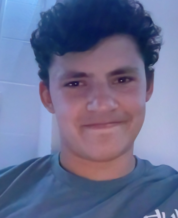

Predicted:  tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]], dtype=torch.int32)
Traits detected:
Blurry
Male
Mouth_Slightly_Open
No_Beard
Wearing_Hat
Young


In [37]:
printResults('./imgo.jpg')

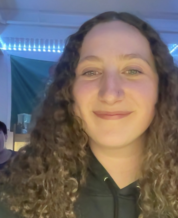

Predicted:  tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1]], dtype=torch.int32)
Traits detected:
Blurry
Male
Narrow_Eyes
No_Beard
Wavy_Hair
Wearing_Hat
Young


In [38]:
printResults('./imgp.jpg')

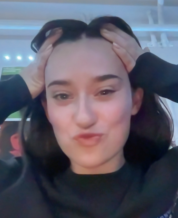

Predicted:  tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]], dtype=torch.int32)
Traits detected:
Blurry
Male
No_Beard
Pointy_Nose
Wearing_Hat
Young


In [39]:
printResults('./imgq.jpg')

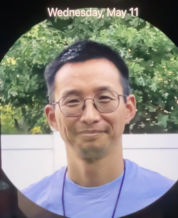

Predicted:  tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
         1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=torch.int32)
Traits detected:
Big_Nose
Black_Hair
Eyeglasses
Male
Mouth_Slightly_Open
No_Beard
Receding_Hairline
Young


In [40]:
printResults('./imgr.jpg')